# QuantumSim - Quantum Approximation Optimization Algorithm (QAOA)
Author: Nico Kuijpers<br>
Date: May 4, 2025

The Quantum Approximation Optimization Algorithm (QAOA) is an example of a Variational Quantum Algorithm (VQA).
QAOA can be applied to find approximate solutions to combinatorial optimization problems.

In this notebook, we introduce the Maximum Cut (or Max-Cut) problem and we show how QAOA can be implemented in 
QuantumSim to find an approximate solution for the Max-Cut problem.

The description of the Max-Cut problem and QAOA in this notebook is adapted from Chapter 12 of:<br>
Robert S. Sutor, 
Dancing with Qubits: From qubits to algorithms, embark on the quantum computing journey shaping our future,
second edition, Packt Publishing, Birmingham, UK, ISBN 978-1-83763-675-4

Reference to QAOA:<br>
Edward Farhi, Jeffrey Goldstone, and Sam Gutmann. 
A Quantum Approximate Optimization Algorithm. 
arXiv:1411.4028, November 2014.
https://arxiv.org/pdf/1411.4028

Qiskit tutorials to implement QAOA in Qiskit:<br>
https://qiskit-community.github.io/qiskit-algorithms/tutorials/05_qaoa.html

https://qiskit-rigetti.readthedocs.io/en/v0.4.1/examples/qaoa_qiskit.html

In this notebook we use QuantumSim.

In [1]:
from quantumsim import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Introduction


Combinatorial optimization problems are mathematical problems for which the objective is to find a solution with minimum cost. 
Finding an optimal solution usually requires a search through all possible solutions. For these problems, the search space grows
exponentially (or worse) with the problem size. To ensure that a solution of minimum cost will be found, the entire search space has to 
be traversed.

A well-known example of a combinatorial optimization problem is the Traveling Salesman Problem (TSP). 
In TSP, the salesman has to visit a number of cities exactly once and return to the starting city. 
An optimal solution to the TSP is defined as the shortest route that starts and ends at the same city and visits each city exactly once.
To be sure that an optimal solution is found, every possible route has to be tried. For $N$ cities, the number of possible routes is $(N-1)!$. 
For $10$ cities, the number of possible routes is $10! = 3628800$. For $15$ cities, it is $15!= 1307674368000$.

Finding an optimal solution for TSP by computing the length of each possible route is called a *brute force* approach.
Such approach is not feasible on classical computers for a larger number of cities (for example $N \geq 20$). 
Therefore, optimization problems such as TSP are usually solved using *heuristic algorithms* or *approximation algorithms*.

Another example of a combinatorial optimization problem is the Maximum Cut or Max-Cut problem. In this notebook, we introduce the Max-Cut
problem and find solutions using a brute-force approach, a heuristic approach (simulated annealing), and using QAOA.

# Max-cut problem
Let $\mathbf{G}(\mathbf{N},\mathbf{E})$ be a graph with nodes $\mathbf{N}$ and edges $\mathbf{E}$.
Let $\mathbf{U}$ be a proper nonempty subset of $\mathbf{N}$. 
This means $\mathbf{U}$ has at least one element of $\mathbf{N}$, but not all. 
$\mathbf{U}'$ is the *complement* of $\mathbf{U}$, i.e., it contains all elements of $\mathbf{N}$ 
that are not in $\mathbf{U}$. Thus, both $\mathbf{U}$ and $\mathbf{U}'$ are not empty.

We define $\delta(\mathbf{U})$ as the set of all edges $u u' \in \mathbf{E}$ 
for which $u \in \mathbf{U}$ and $u' \in \mathbf{U}'$. 
$\delta(\mathbf{U})$ is called a *cut* of graph $\mathbf{G}(\mathbf{N},\mathbf{E})$. The size of $\delta(\mathbf{U})$ is
denoted by $|\delta(\mathbf{U})|$. It is the number of edges that connect nodes in $\mathbf{U}$ with nodes in $\mathbf{U}'$.

The *Maximum Cut Problem* or *Max-Cut Problem* for graph $\mathbf{G}(\mathbf{N},\mathbf{E})$ is to find a proper nonempty subset $\mathbf{U}$ of $\mathbf{N}$ such that $|\delta(\mathbf{U})|$ is as large as possible. Note that $\mathbf{U}$ does
not have to be unique. We call a $\mathbf{U}$ with maximum $|\delta(\mathbf{U})|$ a *maximum cut*.

The Max-Cut problem is an optimization problem. The goal is to maximize $|\delta(\mathbf{U})|$.

### Example
Below a graph $\mathbf{G}(\mathbf{N},\mathbf{E})$ is defined with $4$ nodes and $8$ edges. 
The graph is defined and displayed using *NetworkX*, which is a Python package for complex networks.
It has functionality for the creation and visualisation of graphs.

See https://networkx.org/


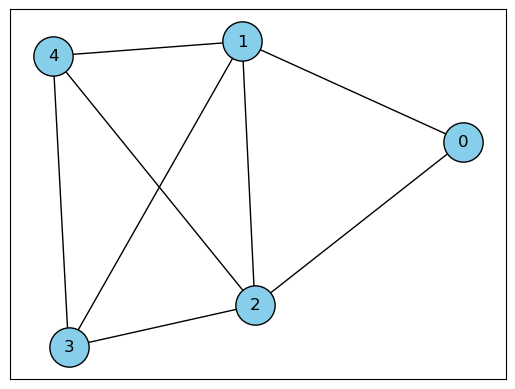

In [2]:
import networkx as nx

# Define nodes and edges
nodes = [0, 1, 2, 3, 4]
edges = [(0,1), (0,2), (1,2), (1,3), (2,3), (1,4), (2,4), (3,4)]

# Construct the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Layout to draw the graph
pos = nx.spring_layout(G, seed=42)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800, edgecolors='black')
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)


Let's divide the nodes of $\mathbf{G}(\mathbf{N},\mathbf{E})$ in $\mathbf{U}$ and $\mathbf{U}'$.
$\mathbf{U}$ contains nodes $0$ and $2$. $\mathbf{U}'$ contains nodes $1$ and $3$.

We call this a *partition*. Below, a dictionary of key-value pairs is defined to represent this partition. 
All nodes are keys and values are either $0$ or $1$. 
For node $n \in \mathbf{N}$ value $0$ means $n \in \mathbf{U}$ and value $1$ means $n \in \mathbf{U}'$.

In [3]:
partition = {0:0, 1:1, 2:0, 3:1, 4:0}

Below Python function `show_graph` is defined to draw a graph showing the nodes in $\mathbf{U}$ in blue and the nodes in $\mathbf{U}'$ in green. Edges $u u' \in \delta(\mathbf{U})$ are shown in red.

In [4]:
import networkx as nx

def show_graph_partition(nodes, edges, partition):
    """
    Show graph partition

    Parameters:
    nodes        : list of nodes 
    edges        : list of edges
    partition    : graph partition
    """

    # Construct the graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # Layout to draw the graph
    pos = nx.spring_layout(G, seed=42)

    # Colors for the nodes
    colors = ['skyblue' if partition[node] == 0 else 'lightgreen' for node in G.nodes()]

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=800, edgecolors='black')
    nx.draw_networkx_labels(G, pos)

    # Divide the edges between `cut` edges and `same` edges
    cut_edges = [(u, v) for u, v in G.edges() if partition[u] != partition[v]]
    same_edges = [(u, v) for u, v in G.edges() if partition[u] == partition[v]]

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=same_edges, width=1.5, style='solid', edge_color='black')
    nx.draw_networkx_edges(G, pos, edgelist=cut_edges, width=2.5, style='dashed', edge_color='red')

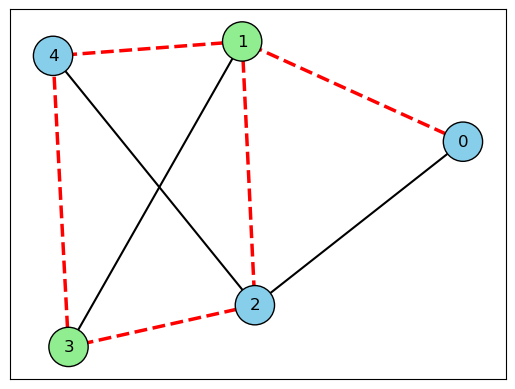

In [5]:
show_graph_partition(nodes, edges, partition)

For a given partition $\mathbf{U}$ and $\mathbf{U}'$, the number of edges in the cut, $|\delta(\mathbf{U})|$, can
be computed by function `cut_size` defined below.

In [6]:
def cut_size(edges, partition):
    return sum(1 for u, v in edges if partition[u] != partition[v])

For the example given above, the cut size can be determined:

In [7]:

print(f"Partition: {partition}")
print(f"Cut size for this partition: {cut_size(edges, partition)}")

Partition: {0: 0, 1: 1, 2: 0, 3: 1, 4: 0}
Cut size for this partition: 5


## Brute-force approach
The Max-Cut problem is **NP-Hard**. This means that the problem cannot be solved using a determenistic algorithm 
in polynomial time. Below we show a brute-force approach where each partition is tried, except for partitions with all zeros or all ones.
One of the partitions for which $|\delta(\mathbf{U})|$ is maximum is returned, together with the corresponding cut size. 
Note that this algorithm has time complexity $\mathcal{O}(2^N)$ with $N = |\mathbf{N}|$, i.e., the number of nodes.

In [8]:
def maxcut_bruteforce(nodes, edges):
    """
    Finds an optimal solution of the max-cut problem

    Parameters:
    nodes        : list of nodes 
    edges        : list of edges

    Returns:
    partition with maximum cut size
    cut size of this partition
    """
    nr_nodes = len(nodes)
    nr_partitions = 2**nr_nodes
    max_cut_size = 0
    for p in range(1,nr_partitions-1):
        binary_digits = format(p, f'0{nr_nodes}b')
        partition = {}
        for n in nodes:
            partition[n] = 0 if binary_digits[n] == '0' else 1
        current_cut_size = cut_size(edges, partition)
        print(f"Partition {partition} has cut size {current_cut_size}")
        if current_cut_size > max_cut_size:
            max_cut_size = current_cut_size
            max_cut_partition = partition.copy()
        
    return max_cut_partition, max_cut_size

Apply the brute force algorithm to find an optimal solution for the Max-Cut problem.

In [9]:
max_cut_partition, max_cut_size = maxcut_bruteforce(nodes, edges)
print(f"Max-cut partition: {max_cut_partition}")
print(f"Cut size for this partition: {max_cut_size}")

Partition {0: 0, 1: 0, 2: 0, 3: 0, 4: 1} has cut size 3
Partition {0: 0, 1: 0, 2: 0, 3: 1, 4: 0} has cut size 3
Partition {0: 0, 1: 0, 2: 0, 3: 1, 4: 1} has cut size 4
Partition {0: 0, 1: 0, 2: 1, 3: 0, 4: 0} has cut size 4
Partition {0: 0, 1: 0, 2: 1, 3: 0, 4: 1} has cut size 5
Partition {0: 0, 1: 0, 2: 1, 3: 1, 4: 0} has cut size 5
Partition {0: 0, 1: 0, 2: 1, 3: 1, 4: 1} has cut size 4
Partition {0: 0, 1: 1, 2: 0, 3: 0, 4: 0} has cut size 4
Partition {0: 0, 1: 1, 2: 0, 3: 0, 4: 1} has cut size 5
Partition {0: 0, 1: 1, 2: 0, 3: 1, 4: 0} has cut size 5
Partition {0: 0, 1: 1, 2: 0, 3: 1, 4: 1} has cut size 4
Partition {0: 0, 1: 1, 2: 1, 3: 0, 4: 0} has cut size 6
Partition {0: 0, 1: 1, 2: 1, 3: 0, 4: 1} has cut size 5
Partition {0: 0, 1: 1, 2: 1, 3: 1, 4: 0} has cut size 5
Partition {0: 0, 1: 1, 2: 1, 3: 1, 4: 1} has cut size 2
Partition {0: 1, 1: 0, 2: 0, 3: 0, 4: 0} has cut size 2
Partition {0: 1, 1: 0, 2: 0, 3: 0, 4: 1} has cut size 5
Partition {0: 1, 1: 0, 2: 0, 3: 1, 4: 0} has cut

Show the solution to the Max-Cut problem as found by the brute force algorithm.

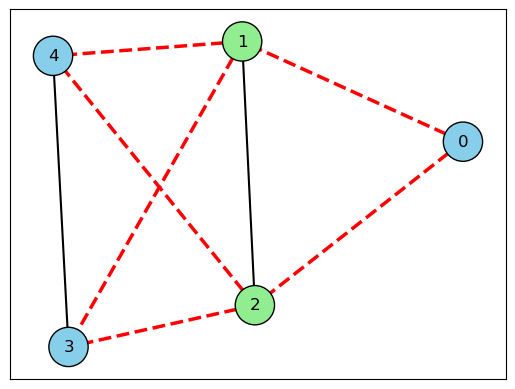

In [10]:
show_graph_partition(nodes, edges, max_cut_partition)

## Simulated Annealing
A well-known heuristic approach to find a global optimum is *simulated annealing*.
This algorithm can also be used to find a solution for the max-cut problem.

The term *annealing* comes from metallurgy and is a technique to first heat and then cool a material in a controlled way.

The simulated annealing algorithm can be described as follows:
1. Choose a number of iterations *max_iter*, an initial temperature $T$, and a *cooling rate* $r$, $0 < r < 1$ (usually $r \in [0.9 - 0.99]$).
2. Choose an initial (random) solution.
3. Compute the cost of the current solution, $C_\text{current}$.
4. Obtain a candidate solution by making a small change to the current solution.
5. Compute the cost of the candidate solution, $C_\text{candidate}$.
6. Compute the difference in cost, $\Delta C = C_\text{current} - C_\text{candidate}$.
7. Accept the candidate solution if its cost is lower, i.e., $\Delta C > 0$, else accept it with probability $P = e^{\Delta C/T}$.
8. Reduce temperature $T$: $T \leftarrow T \cdot r$.
9. Repeat steps 4. through 8. *max_iter* times.

Below, simulated annealing is applied to find a solution for the max-cut problem. 
Note that instead of minimizing some cost, here *max_cut_size* is maximized.

In [11]:
import random
import math

# Initialize a random partition (dict: node -> 0 or 1)
def random_partition(nodes:list) -> dict:
    """
    Constructs a random partition for a given list of nodes

    Parameters:
    nodes : list of nodes 

    Returns:
    random partition
    """
    return {node: random.randint(0, 1) for node in nodes}

# Flip one random node's partition
def neighbor(partition:dict, nodes:list) -> dict:
    """
    Constructs a neighbor partition for a given partition

    Parameters:
    partition : partition for which neighbor should be constructed
    nodes     : list of nodes 

    Returns:
    neighbor partition
    """
    neighbor_partition = partition.copy()
    node_to_flip = random.choice(nodes)
    neighbor_partition[node_to_flip] ^= 1  # Flip 0 <-> 1
    return neighbor_partition

# Simulated Annealing algorithm
def simulated_annealing(nodes:list, edges:list, initial_temp:float=10.0, cooling_rate:float=0.95, max_iter:int=100) -> tuple[dict, float, list]:
    """
    Finds an approximation of the optimal solution of the max-cut problem

    Parameters:
    nodes        : list of nodes 
    edges        : list of edges
    initial_temp : initial temperature
    cooling_rate : cooling rate to reduce temperature each step
    max_iter     : maximum number of iterations

    Returns:
    partition with maximum cut size
    cut size of this partition
    history of cut sizes
    """
    current_partition = random_partition(nodes)
    current_cut_size = cut_size(edges, current_partition)
    T = initial_temp
    max_cut_partition = current_partition.copy()
    max_cut_size = current_cut_size
    history_cut_size = np.zeros(max_iter)

    for step in range(max_iter):
        candidate_partition = neighbor(current_partition, nodes)
        candidate_cut_size = cut_size(edges, candidate_partition)
        delta = candidate_cut_size - current_cut_size
        if delta > 0 or random.random() < math.exp(delta / T):
            current_partition = candidate_partition
            current_cut_size = candidate_cut_size

            if current_cut_size > max_cut_size:
                max_cut_partition = current_partition.copy()
                max_cut_size= current_cut_size

        T *= cooling_rate
        history_cut_size[step] = current_cut_size

    return max_cut_partition, max_cut_size, history_cut_size

Find an approximate solution to the Max-Cut problem using simulated annealing.

In [12]:
max_cut_partition, max_cut_size, history_cut_size = simulated_annealing(nodes, edges)
print(f"Max-cut partition: {max_cut_partition}")
print(f"Cut size for this partition: {max_cut_size}")

Max-cut partition: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1}
Cut size for this partition: 6


Show the approximate solution to the Max-Cut problem.

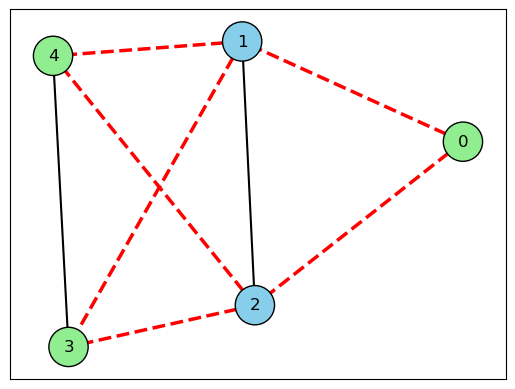

In [13]:
show_graph_partition(nodes, edges, max_cut_partition)

Show the cut size of `current_partition` during simulated annealing.

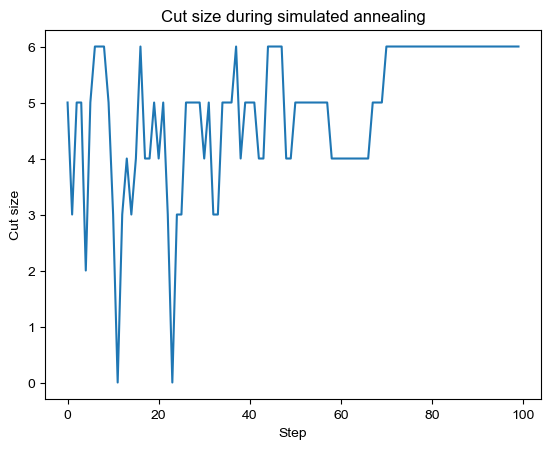

In [14]:
import matplotlib.pyplot as plt

plt.plot(history_cut_size)
plt.title('Cut size during simulated annealing')
plt.xlabel('Step')
plt.ylabel('Cut size')
plt.show()

## QAOA circuit
Let $N = |\mathbf{N}|$ be the number of nodes. 
We define bit string $x = x_0 x_1 \ldots x_{N-1}$ of length $N$ as follows:

$x_n = 
\begin{cases}
0 & \text{if } n \in \mathbf{U} \\
1 & \text{if } n \in \mathbf{U}'
\end{cases}
$

Below, a python function is defined to create a QAOA circuit of $N$ qubits for given $\gamma$, $\beta$, and graph $\mathbf{G}(\mathbf{N},\mathbf{E})$.

Executing and measuring this circuit multiple times results in a distribution of possible solutions. The most occurring solutions represent
partitions with high max-cut size.

For a more detailed explanation of QAOA and the role of $\gamma$ and $\beta$, see the references at the beginning of this notebook.

In [15]:
# Create the QAOA circuit
def qaoa_circuit(gamma:list[float], beta:list[float], nodes:list, edges:list, p:int) -> Circuit:
    """
    Creates a quantum circuit of p layers for the Quantum Approximate Optimiziation Algorithm

    Parameters:
    gamma : list of length p containing values for gamma, 0 < gamma < pi
    beta  : list of length p containing values for beta, 0 < beta < pi
    nodes : list of nodes 
    edges : list of edges
    p     : number of layers

    Returns:
    QAOA circuit with p layers
    """

    # Consistency check
    if len(gamma) != p or len(beta) != p:
        raise ValueError(f"Lists gamma and beta should be of length p = {p}")
    
    # Create circuit witn n qubits, where n is the number of nodes
    n = len(nodes)
    circuit = Circuit(n)
    
    # Initialize circuit by applying the Hadamard gate to all qubits
    for q in range(n):
        circuit.hadamard(q)

    # Construct p alternating cost and mixer layers
    for i in range(p):
    
        # Construct cost layer with parameter gamma[i]
        for edge in edges:
            circuit.cnot(edge[0], edge[1])
            circuit.rotate_z(2 * gamma[i], edge[1])
            circuit.cnot(edge[0], edge[1])
        
        # Construct mixer layer with parameter beta[i]
        for q in range(n):
            circuit.rotate_x(2 * beta[i], q)
    
    #return circuit
    return circuit

Create and execute a circuit with one cost layer and one mixer layer with $\gamma = \pi/8$ and $\beta = \pi/3$.

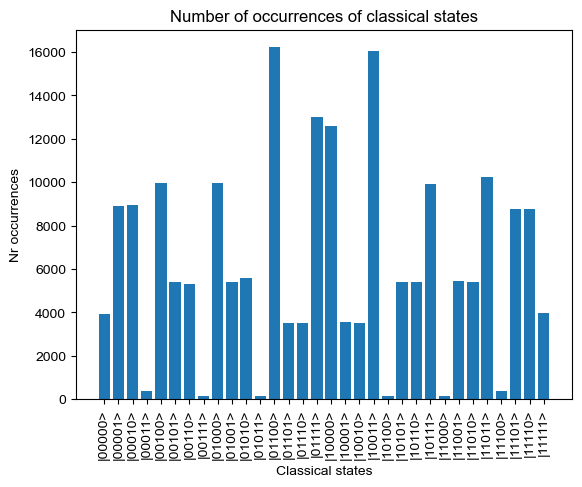

In [16]:
gamma = [np.pi/8]
beta = [np.pi/3]
nr_measurements = 200000
circuit = qaoa_circuit(gamma, beta, nodes, edges, 1)
result = QuantumUtil.measure_circuit(circuit, nr_measurements=nr_measurements)
QuantumUtil.histogram_of_classical_states(result)

Below, a function is defined to obtain the partition from the most occurring measurement.

In [17]:
def compute_partition(nodes:list, edges:list, result:list) -> dict:
    """
    Compute partition from the most occurring measurement

    Parameters:
    nodes  : list of nodes
    edges  : list of edges
    result : list of strings containing measurements

    Returns:
    Partition corresponding to most occurring result
    """

    # Count occurrences of each string in result
    counter = Counter(result)

    # Get the most occurring string from result
    most_common_string = counter.most_common(1)[0][0]

    # Determine partition corresponding to the most occurring string
    bit_string = most_common_string[1:-1]
    partition = {node: 0 if bit_string[node] == '0' else 1 for node in nodes}

    # Return partition corresponding to the most occurrring string in result
    return partition

Use this function of determine the partition, compute its cut size and show the partition.

Partition {0: 0, 1: 1, 2: 1, 3: 0, 4: 0} has cut size 6


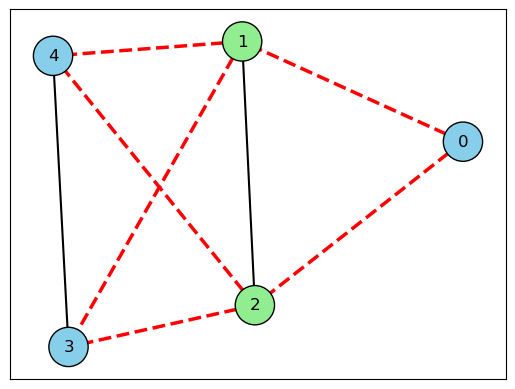

In [18]:
partition = compute_partition(nodes, edges, result)
partition_cut_size = cut_size(edges, partition)
print(f"Partition {partition} has cut size {partition_cut_size}")

show_graph_partition(nodes, edges, partition)

Below, a function is defined to compute the average of the cut size from all the measurements. It is expected that if a QAOA circuit performs better,
the average cut size will increase.

We will use this function to compare the performance of QAOA circuits for the same graphs, but with different values of $\gamma$, $\beta$, and $p$.

In [19]:
def compute_average_cut_size(nodes:list, edges:list, result:list) -> float:
    """
    Compute average cut size

    Parameters:
    nodes  : list of nodes
    edges  : list of edges
    result : list of measurements

    Returns:
    average cut size
    """
    occurrences = Counter(result)
    total_nr_occurrences = len(result)
    sum_cut_size = 0
    for string, count in occurrences.items():
        bit_string = string[1:-1]
        partition = {node: bit_string[node] for node in nodes}
        partition_cut_size = cut_size(edges, partition)
        sum_cut_size += partition_cut_size*count

    average_cut_size = sum_cut_size/total_nr_occurrences
    return average_cut_size

In [20]:
average_cut_size = compute_average_cut_size(nodes, edges, result)
print(f"Average cut size is {average_cut_size}")

Average cut size is 4.019415


Below, a circuit with $p=2$ is created. Both layers have $\gamma = \pi/8$ and $\beta = \pi/3$.

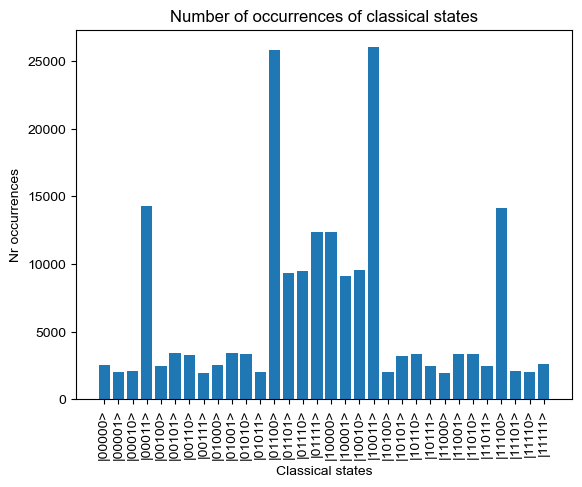

In [21]:
p = 2
gamma = [np.pi/8] * p
beta = [np.pi/3] * p
nr_measurements = 200000
circuit = qaoa_circuit(gamma, beta, nodes, edges, p)
result = QuantumUtil.measure_circuit(circuit, nr_measurements=nr_measurements)
QuantumUtil.histogram_of_classical_states(result)

From the histogram it can be observed that the partitions with higher cut size occur more often when $p=2$.

Partition {0: 1, 1: 0, 2: 0, 3: 1, 4: 1} has cut size 6


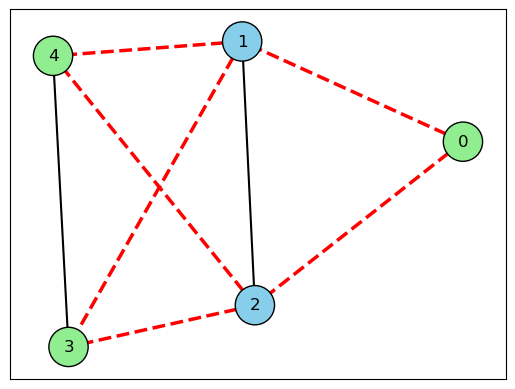

In [22]:
partition = compute_partition(nodes, edges, result)
partition_cut_size = cut_size(edges, partition)
print(f"Partition {partition} has cut size {partition_cut_size}")

show_graph_partition(nodes, edges, partition)

Let's compute the average cut size for this QAOA instance.

In [23]:
average_cut_size = compute_average_cut_size(nodes, edges, result)
print(f"Average cut size is {average_cut_size}")

Average cut size is 4.448375


Below, the average cut size is computed for increasing $p$ and then plotted. For each layer, $\gamma$ and $\beta$ are randomly chosen between $0$ and $\pi$.
Run this cell multiple times, because the results are related to the randomly chosen values for $\gamma$ and $\beta$.

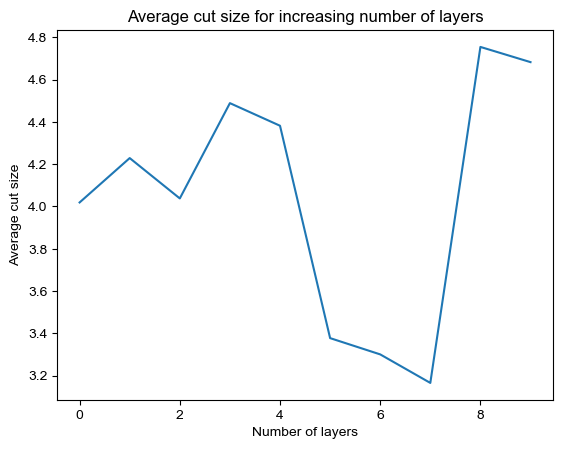

In [24]:
import matplotlib.pyplot as plt

nr_measurements = 1000
average_cut_size = []
p_max = 20
gamma = np.random.uniform(0, np.pi, p_max)
beta = np.random.uniform(0, np.pi, p_max)
for p in range(10):
    circuit = qaoa_circuit(gamma[:p], beta[:p], nodes, edges, p)
    result = QuantumUtil.measure_circuit(circuit, nr_measurements=nr_measurements)
    average_cut_size.append(compute_average_cut_size(nodes, edges, result))

plt.plot(average_cut_size)
plt.title('Average cut size for increasing number of layers')
plt.xlabel('Number of layers')
plt.ylabel('Average cut size')
plt.show()

Let's get back to $p=1$ and compute the average cut sum for different values of $\gamma$ and $\beta$, $0 < \gamma, \beta, < \pi$. 
The result is a 2-dimensional array.

In [25]:
p = 1
nr_steps = 32
nr_measurements = 1000
landscape = np.zeros((nr_steps, nr_steps), dtype=float)
for i in range(nr_steps):
    gamma = i*(np.pi/nr_steps)
    for j in range(nr_steps):
        beta = j*(np.pi/nr_steps)
        circuit = qaoa_circuit([gamma], [beta], nodes, edges, p)
        result = QuantumUtil.measure_circuit(circuit, nr_measurements=nr_measurements)
        average_cut_size = compute_average_cut_size(nodes, edges, result)
        landscape[i,j] = average_cut_size

Plot the 2-dimensional array as a surface.

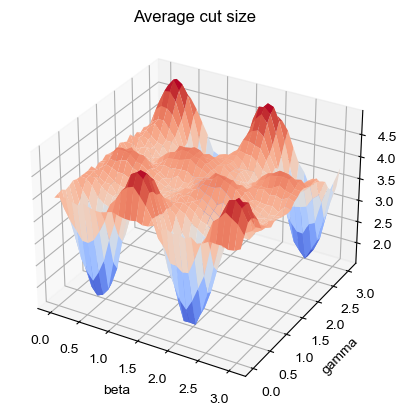

In [26]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0, np.pi, np.pi/nr_steps)
y = np.arange(0, np.pi, np.pi/nr_steps)
X, Y = np.meshgrid(x, y)
Z = landscape

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
plt.title('Average cut size')
plt.xlabel('beta')
plt.ylabel('gamma')
plt.show()

As can be observed in the surface plot, the performance of a QAOA circuit is dependent on the chosen values for $\gamma$ and $\beta$.

Below, the QAOA algorithm is part of a classical algorithm to find optimal values of $\gamma$ and $\beta$. 
As cost function, the negative value of the average cut size is used.
Here, the COBYLA algorithm is used to minimize the cost function.

COBYLA is short for Constrained Optimization BY Linear Approximation and is provided by SciPy.

See: https://docs.scipy.org/doc/scipy/reference/optimize.minimize-cobyla.html

In [27]:
from scipy.optimize import minimize

def optimization(parameters):
    gamma, beta = parameters
    circuit = qaoa_circuit([gamma], [beta], nodes, edges, p=1)
    result = QuantumUtil.measure_circuit(circuit, nr_measurements=nr_measurements)
    average_cut_size = compute_average_cut_size(nodes, edges, result)
    return -average_cut_size

res = minimize(optimization, [np.pi/2, np.pi/2], method='COBYLA')
print(res)

gamma = res.x[0]
beta = res.x[1]
print(f"gamma = {gamma}")
print(f"beta = {beta}")

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.926
       x: [ 2.931e+00  1.913e+00]
    nfev: 29
   maxcv: 0.0
gamma = 2.9314792188542462
beta = 1.9126293343667522


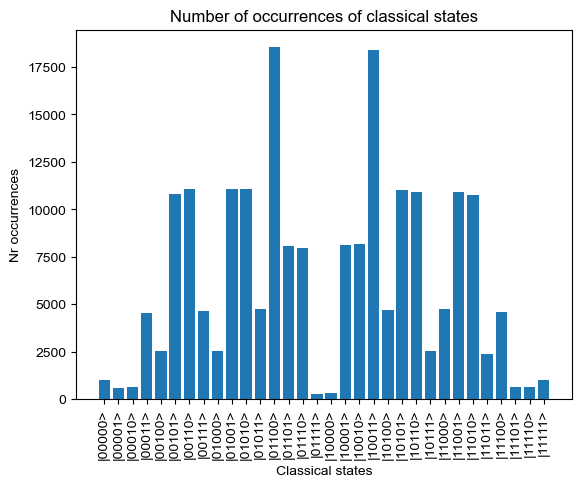

In [28]:

nr_measurements = 200000
circuit = qaoa_circuit([gamma], [beta], nodes, edges, p=1)
result = QuantumUtil.measure_circuit(circuit, nr_measurements=nr_measurements)
QuantumUtil.histogram_of_classical_states(result)

In [29]:
average_cut_size = compute_average_cut_size(nodes, edges, result)
print(f"Average cut size is {average_cut_size}")

Average cut size is 4.909


Partition {0: 0, 1: 1, 2: 1, 3: 0, 4: 0} has cut size 6


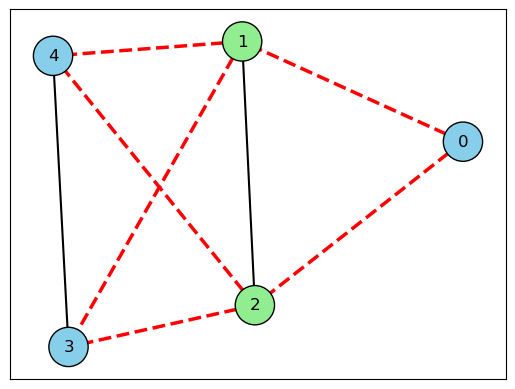

In [30]:
partition = compute_partition(nodes, edges, result)
partition_cut_size = cut_size(edges, partition)
print(f"Partition {partition} has cut size {partition_cut_size}")

show_graph_partition(nodes, edges, partition)

In [31]:
circuit.print_circuit()

Hadamard on qubit 0
Hadamard on qubit 1
Hadamard on qubit 2
Hadamard on qubit 3
Hadamard on qubit 4
CNOT with control qubit 0 and target qubit 1
Rotate Z with theta = 1.866 π on qubit 1
CNOT with control qubit 0 and target qubit 1
CNOT with control qubit 0 and target qubit 2
Rotate Z with theta = 1.866 π on qubit 2
CNOT with control qubit 0 and target qubit 2
CNOT with control qubit 1 and target qubit 2
Rotate Z with theta = 1.866 π on qubit 2
CNOT with control qubit 1 and target qubit 2
CNOT with control qubit 1 and target qubit 3
Rotate Z with theta = 1.866 π on qubit 3
CNOT with control qubit 1 and target qubit 3
CNOT with control qubit 2 and target qubit 3
Rotate Z with theta = 1.866 π on qubit 3
CNOT with control qubit 2 and target qubit 3
CNOT with control qubit 1 and target qubit 4
Rotate Z with theta = 1.866 π on qubit 4
CNOT with control qubit 1 and target qubit 4
CNOT with control qubit 2 and target qubit 4
Rotate Z with theta = 1.866 π on qubit 4
CNOT with control qubit 2 an

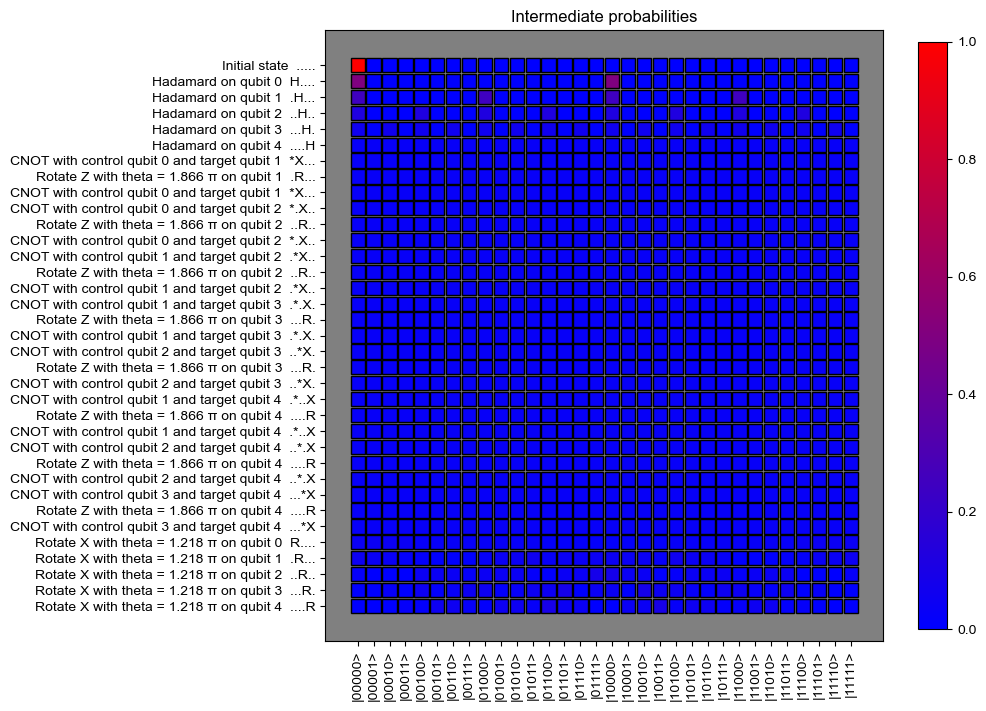

In [32]:
QuantumUtil.show_all_probabilities(circuit)

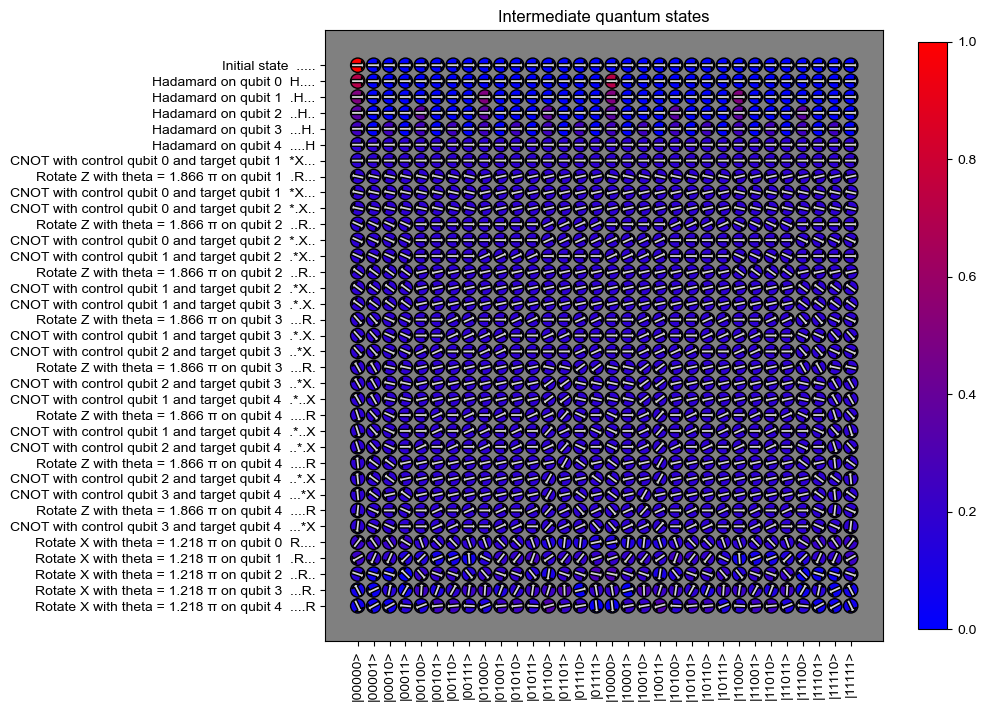

In [33]:
QuantumUtil.show_all_intermediate_states(circuit)